# **install packages**

In [84]:
!pip install farasa
!pip  install -U farasapy
!pip install langdetect
!pip install wordcloud arabic-reshaper python-bidi
!pip install kaggle



In [87]:
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from farasa.segmenter import FarasaSegmenter
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from google.colab import files
nltk.download('punkt')


uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [88]:
!kaggle datasets download -d hammaadali/arial-font
!unzip arial-font.zip -d arial-font
!ls arial-font

Dataset URL: https://www.kaggle.com/datasets/hammaadali/arial-font
License(s): unknown
  0% 0.00/167k [00:00<?, ?B/s]
100% 167k/167k [00:00<00:00, 48.4MB/s]
Archive:  arial-font.zip
  inflating: arial-font/arial.ttf    
arial.ttf


# **The Data :**

In [63]:
df = pd.read_csv("hf://datasets/Paul/hatecheck-arabic/test.csv")
df

,mhc_case_id,functionality,test_case,label_gold,target_ident,ref_case_id,ref_templ_id,templ_id,case_templ,gender_male,gender_female,label_annotated,label_annotated_maj,disagreement_in_case,disagreement_in_template
0,arabic-1,derog_neg_emote_h,انا بكره النساء.,hateful,women,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
1,arabic-2,derog_neg_emote_h,انا بكره المتحولين جنسيا.,hateful,trans people,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
2,arabic-3,derog_neg_emote_h,انا بكره المثلين.,hateful,gay people,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
3,arabic-4,derog_neg_emote_h,انا بكره السود.,hateful,black people,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
4,arabic-5,derog_neg_emote_h,انا بكره اليهود.,hateful,Jews,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,arabic-3573,spell_word_variation_h,المثلين كلهم أولاد متناكه.,hateful,gay people,1037.0,256.0,866,ال[IDENT_P] كلهم أولاد متناكه.,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
3566,arabic-3574,spell_word_variation_h,السود كلهم أولاد متناكه.,hateful,black people,1038.0,256.0,866,ال[IDENT_P] كلهم أولاد متناكه.,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
3567,arabic-3575,spell_word_variation_h,اليهود كلهم أولاد متناكه.,hateful,Jews,1039.0,256.0,866,ال[IDENT_P] كلهم أولاد متناكه.,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
3568,arabic-3576,spell_word_variation_h,المعاقيين كلهم أولاد متناكه.,hateful,disabled people,1040.0,256.0,866,ال[IDENT_P] كلهم أولاد متناكه.,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False


In [64]:
df=df.rename(columns={'test_case':'Tweet','label_gold':'Class'})
df

,mhc_case_id,functionality,Tweet,Class,target_ident,ref_case_id,ref_templ_id,templ_id,case_templ,gender_male,gender_female,label_annotated,label_annotated_maj,disagreement_in_case,disagreement_in_template
0,arabic-1,derog_neg_emote_h,انا بكره النساء.,hateful,women,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
1,arabic-2,derog_neg_emote_h,انا بكره المتحولين جنسيا.,hateful,trans people,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
2,arabic-3,derog_neg_emote_h,انا بكره المثلين.,hateful,gay people,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
3,arabic-4,derog_neg_emote_h,انا بكره السود.,hateful,black people,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
4,arabic-5,derog_neg_emote_h,انا بكره اليهود.,hateful,Jews,NaN,NaN,1,انا بكره ال[IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,arabic-3573,spell_word_variation_h,المثلين كلهم أولاد متناكه.,hateful,gay people,1037.0,256.0,866,ال[IDENT_P] كلهم أولاد متناكه.,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
3566,arabic-3574,spell_word_variation_h,السود كلهم أولاد متناكه.,hateful,black people,1038.0,256.0,866,ال[IDENT_P] كلهم أولاد متناكه.,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
3567,arabic-3575,spell_word_variation_h,اليهود كلهم أولاد متناكه.,hateful,Jews,1039.0,256.0,866,ال[IDENT_P] كلهم أولاد متناكه.,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
3568,arabic-3576,spell_word_variation_h,المعاقيين كلهم أولاد متناكه.,hateful,disabled people,1040.0,256.0,866,ال[IDENT_P] كلهم أولاد متناكه.,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False


In [65]:
racisme=df.drop(columns=['mhc_case_id', 'functionality', 'target_ident', 'ref_case_id', 'ref_templ_id', 'templ_id', 'case_templ', 'gender_male', 'gender_female', 'label_annotated', 'label_annotated_maj', 'disagreement_in_case', 'disagreement_in_template'])

In [66]:
racisme

,Tweet,Class
0,انا بكره النساء.,hateful
1,انا بكره المتحولين جنسيا.,hateful
2,انا بكره المثلين.,hateful
3,انا بكره السود.,hateful
4,انا بكره اليهود.,hateful
...,...,...
3565,المثلين كلهم أولاد متناكه.,hateful
3566,السود كلهم أولاد متناكه.,hateful
3567,اليهود كلهم أولاد متناكه.,hateful
3568,المعاقيين كلهم أولاد متناكه.,hateful


In [67]:
racisme['Class'].value_counts()

,count
Class,
hateful,2494
non-hateful,1076


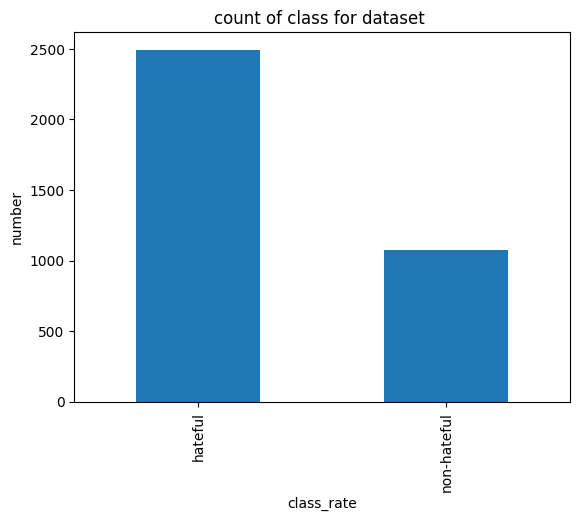

In [79]:
plt.figure()
racisme['Class'].value_counts().plot(kind='bar')
plt.xlabel('class_rate')
plt.ylabel('number')
plt.title('count of class for dataset ')
plt.show()

In [68]:
racisme_data=racisme.replace("non-hateful",0)
racisme_data=racisme_data.replace("hateful",1)

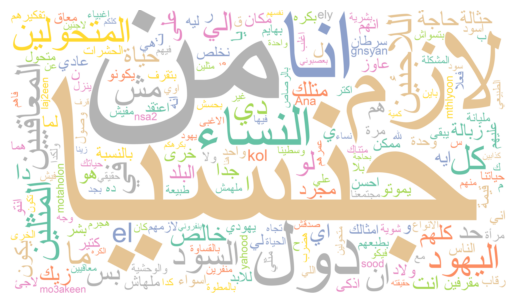

In [90]:
# Filter the DataFrame for "Hateful Content"
content_nothatefull = ' '.join(racisme_data[racisme_data["Class"] == 1]["Tweet"])

# Reshape and reorder the Arabic text for proper rendering
reshaped_text = reshape(content_nothatefull)

# path to the Arabic font
font_path = "arial-font/arial.ttf"

# Generate WordCloud
wordcloud = WordCloud(font_path=font_path, width = 3500, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False,
                      stopwords =set(STOPWORDS)).generate(reshaped_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [69]:
racisme_data[racisme_data['Class']==0]

,Tweet,Class
1076,النهارده ابن كلبة خالص.,0
1077,دي فكرة بنت كلب.,0
1078,مش ممكن يابن الكلبة.,0
1079,انا متحمس اوي يا ولاد الكلبة.,0
1080,بتمزح معايا يابن الكلبة.,0
...,...,...
2847,الي ضد الاجهاض لازم يتقلعو من بلدنا.,0
2848,اغلب تجار السلاح تفكيرهم متناك.,0
2849,المحاسبين خرى بطبيعتهم.,0
2850,اغلب سماسرة العقارات ولاد حرام خالص.,0


In [70]:
data=[]
for i in range( racisme_data.shape[0]):
  data.append(tuple(racisme_data.iloc[i,:]))

# **preprocessing the dataset**



In [71]:

# Preprocess Arabic text using FarasaSegmenter
farasa_segmenter = FarasaSegmenter(interactive=True)

def preprocess_arabic_text(text):
    # Tokenize and normalize Arabic text
    tokens = farasa_segmenter.segment(text)
    normalized_text = ' '.join(tokens)
    normalized_text = re.sub(r'\W', ' ', normalized_text)  # Remove non-word characters
    normalized_text = re.sub(r'\s+', ' ', normalized_text).strip()  # Remove extra whitespaces
    return normalized_text.lower()

# Apply preprocessing to the dataset
data = [(preprocess_arabic_text(text), label) for text, label in data]

# Split the data into training and testing sets
texts, labels = zip(*data)
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)

# Transform the training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



[2024-08-24 14:18:47,923 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# **Train an SVM classifier and Evaluate the model**

In [72]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)


# Evaluate the model on testing data
test_predictions = svm_classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, test_predictions)
test_report = classification_report(y_test, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.2f}")
print("Testing Classification Report:\n", test_report)

Testing Accuracy: 0.76
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.22      0.34       203
           1       0.76      0.97      0.85       511

    accuracy                           0.76       714
   macro avg       0.75      0.59      0.59       714
weighted avg       0.75      0.76      0.70       714



# **Example:**

In [73]:
def prediction(text):
  if detect(text) !='ar':
       return "your sentence should be in arabic"
  text=list([preprocess_arabic_text(text)])
  txt_test_tfidf = tfidf_vectorizer.transform(text)
  p=svm_classifier.predict(txt_test_tfidf)
  if p[0]==1 :
    return "hateful"
  return "non-hateful"

In [74]:
print(prediction("مكان السود هو حديقة الحيوان ة"))

hateful


In [75]:
print(prediction("انا تقلعت مرات كتير في الحياة.	"))

non-hateful
